# Customer Insurance Benefits Evaluation and Data Obfuscation: Applications of Machine Learning and Linear Algebra

# Contents <a id='back'></a>
* [1. Introduction](#intro)
* [2. Data Exploration and Preprocessing](#data_exploration)
* [3. Exploratory Data Analysis (EDA)](#eda)
* [4. Solving the Tasks Given by the Sure Tomorrow Company](#tasks)
    * [4.1 Similar Customers](#similar_customers)
    * [4.2 Is Customer Likely to Receive Insurance Benefit?](#insurance_benefit1)
    * [4.3 Regression (with Linear Regression)](#regression)
    * [4.4 Obfuscating Data](#data_obfuscation)
* [5. Proving That Data Obfuscation Can Work with Linear Regression](#data_obfuscation_lr)
* [6. Test Linear Regression With Data Obfuscation](#data_obfuscation_test)
* [7. General Conclusion](#general_conclusion)

## 1. Introduction <a id='intro'></a>

The Sure Tomorrow insurance company wants to solve several tasks related to the customer insurance benefits. This project aims to solve the given tasks with machine learning models and secure the privacy of customer data.

### Purpose
To solve the following tasks given by the Sure Tomorrow insurance company:

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

In [1]:
# Data preprocessing and manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.utils import shuffle

# Data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Model buildling and evaluation
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

# Suppress warning messages
import warnings
warnings.filterwarnings('ignore')

[Back to Contents](#back)

## 2. Data Exploration and Preprocessing <a id='data_exploration'></a>

Load the dataset provided by the Sure Tomorrow Insurance company and check for any obvious issus.

In [2]:
# Load the dataset
try:
    data = pd.read_csv('insurance_us.csv')
except:
    data = pd.read_csv('/datasets/insurance_us.csv')

In [3]:
# Have a look at the dataset
data

,Gender,Age,Salary,Family members,Insurance benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


The dataset has 5000 rows (customers) and 5 columns of information related to each customer.

**Description of data**

*Features*

- Gender -  insured person's gender
- Age -  insured person's age
- Salary -  insured person's yearly income
- Family members -  number of insured person's famliy members

*Target*
- Insurance benefits - number of insurance benefits received by an insured person over the last five years


The columns will be renamed in the snake case style.

In [4]:
# Rename the columns
data = data.rename(columns={
    'Gender': 'gender', 
    'Age': 'age', 
    'Salary': 'income', 
    'Family members': 'family_members', 
    'Insurance benefits': 'insurance_benefits'    
})

In [5]:
# Check the data types and missing value
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


There is no missing value. The data types are all correct except that the `age` should have `int64` as the data type.

In [6]:
# Convert the data type of age to int64
data['age'] = data['age'].astype('int64')

# Check if the data type has been converted
data.dtypes

gender                  int64
age                     int64
income                float64
family_members          int64
insurance_benefits      int64
dtype: object

All the data types are correct now. Let's check if there is any duplicate.

In [7]:
# Check for duplicates
data.duplicated().sum()

153

In [8]:
# have a look at the duplicated rows
data[data.duplicated()].head()

,gender,age,income,family_members,insurance_benefits
281,1,39,48100.0,1,0
488,1,24,32900.0,1,0
513,0,31,37400.0,2,0
718,1,22,32600.0,1,0
785,0,20,35800.0,0,0


It is unlikely to have 153 duplicated rows since the total combinations of `age` and `income` are huge. Therefore, we can consider to drop these duplicated rows.

In [9]:
# Find out the number and percentage of duplicated rows
print('Total number of rows:', data.shape[0])
print('Number of duplicated rows:', data.duplicated().sum())
print(f'Percentage of duplicated rows {data.duplicated().mean():.2%}')

print()
print('Remaining number of rows if duplicated rows are dropped ', end='')
print(data.shape[0] - data.duplicated().sum())

Total number of rows: 5000
Number of duplicated rows: 153
Percentage of duplicated rows 3.06%

Remaining number of rows if duplicated rows are dropped 4847


The percentage of duplicated rows is 3.06% and we can safely drop these rows as the remaining 4847 samples are enough to conduct the analysis tasks.

In [10]:
# Drop duplicates
data = data.drop_duplicates().reset_index(drop=True)

# Check if the duplicates have been dropped
data.shape[0]

4847

In [11]:
# Have a look at the descriptive statistics
data.describe()

,gender,age,income,family_members,insurance_benefits
count,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000
mean,0.498453,31.023932,39895.811842,1.203425,0.152259
std,0.500049,8.487995,9972.953985,1.098664,0.468934
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33200.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


No obvious anomaly or outlier.

[Back to Contents](#back)

## 3. Exploratory Data Analysis (EDA) <a id='eda'></a>

One of the tasks is to Find customers who are similar to a given customer. Let's have a quick check on the scatter plots between the variables to detect if there are certain groups (clusters) of customers.

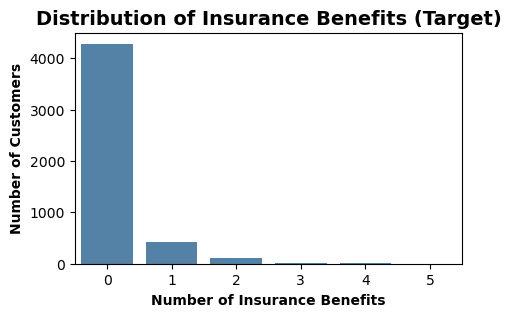

In [12]:
# Check the distributions of the target
plt.figure(figsize=(5,3))
sns.countplot(data, x='insurance_benefits', color='steelblue')

plt.title('Distribution of Insurance Benefits (Target)', fontsize=14, fontweight='bold')
plt.xlabel('Number of Insurance Benefits', fontweight='bold')
plt.ylabel('Number of Customers', fontweight='bold')

plt.show()

In [13]:
# Check the percentage of different groups in target
data['insurance_benefits'].value_counts(normalize=True)

insurance_benefits
0    0.883846
1    0.087270
2    0.023520
3    0.003714
4    0.001444
5    0.000206
Name: proportion, dtype: float64

There are 88.38% of customers did not received any insurance benefit before. The imbalanced targets could be an issue if we deploy a classification model to solve the given tasks.

<Figure size 1200x1200 with 0 Axes>

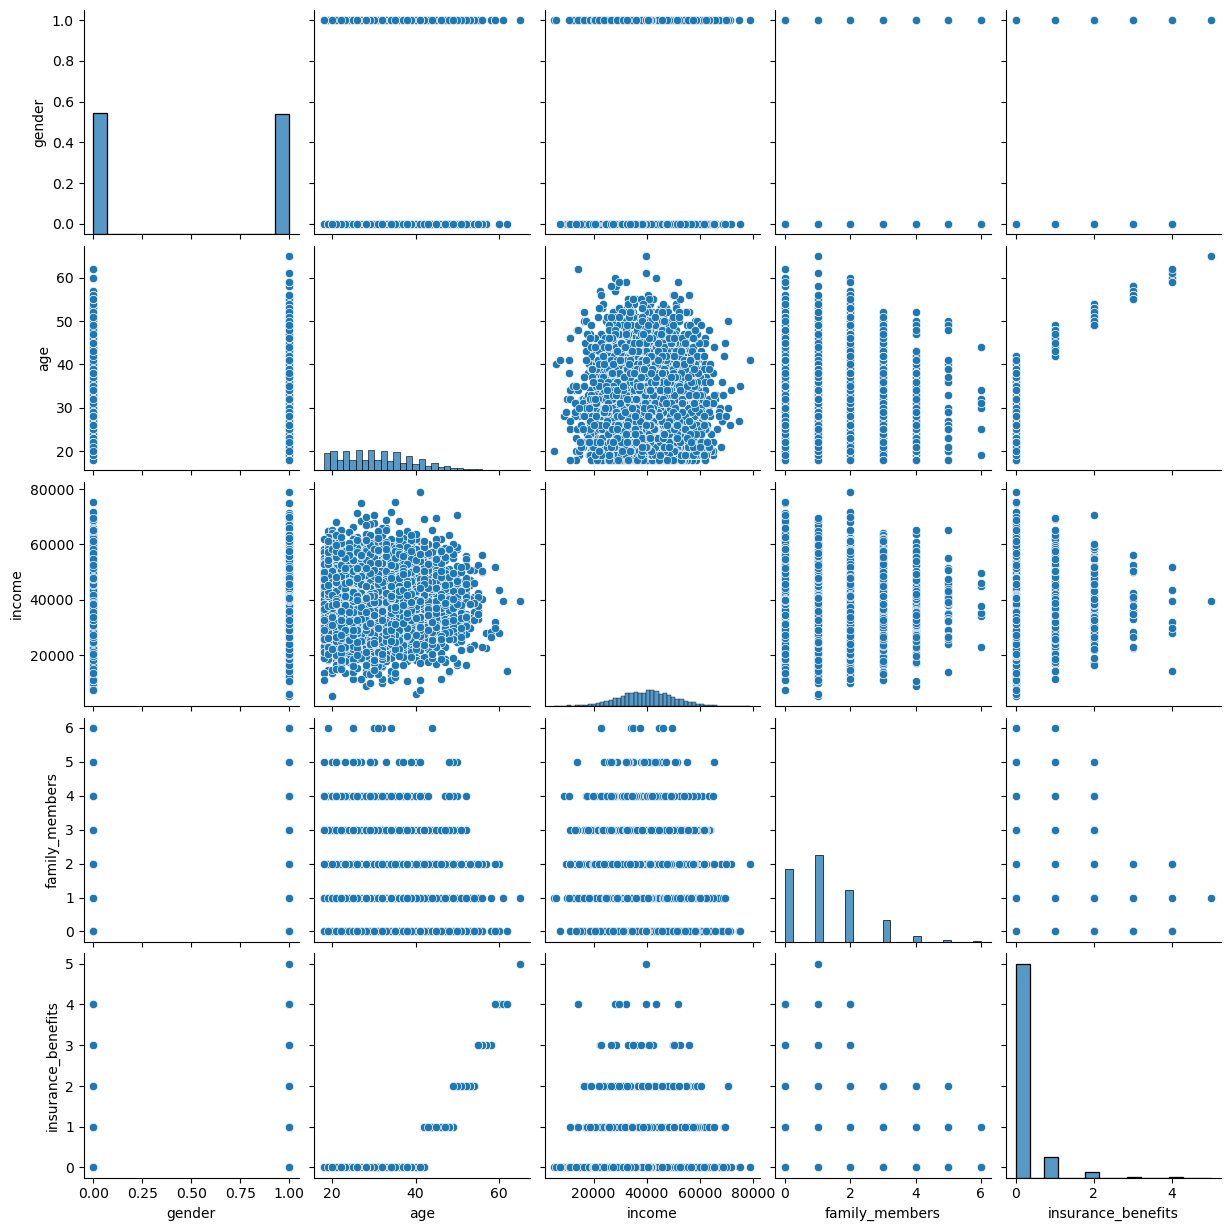

In [14]:
# Plot the histograms and scatter plots of the variables.
plt.figure(figsize=(12,12))
sns.pairplot(data)

plt.show()

It is quite difficult to spot obvious clustesr by observing these scatter plots. Machine learning algorithms will be deployed to solve the tasks.

[Back to Contents](#back)

## 4. Solving the Tasks Given by the Sure Tomorrow Company <a id='tasks'></a>

---

The following classes and functions will be used in this section.

In [15]:
class MyKNNClassifier():
    def __init__(self, k=5, metric='Euclidean'):
        self.k = k
        self.metric = metric        
        
    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
    
    def predict(self, X_test):
        predictions = []
        for x in X_test.values:
            if self.metric == 'Manhattan':
                distances = np.abs(x - self.X_train.values).sum(axis=1)
            elif self.metric == 'Euclidean':
                distances = np.linalg.norm(x - self.X_train.values, axis=1)
               
            knn_indices = distances.argsort()[:self.k]
            knn_classes = self.y_train.iloc[knn_indices]            
            pred = knn_classes.mode()[0]
            
            predictions.append(pred)
        
        return np.array(predictions)

In [16]:
class MyLinearRegression:
    def __init__(self):
        self.weights = None
        
    def fit(self, X_train, y_train):
        # Adding the unities for bias
        X2 = np.append(np.ones([len(X_train), 1]), X_train, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y_train
    
    def predict(self, X_test):
        # Adding the unities for bias
        X3 = np.append(np.ones([len(X_test), 1]), X_test, axis=1)
        y_pred = X3 @ self.weights
        
        return y_pred

In [17]:
def get_knn(data, target_index, k, metric):
    '''
    Returns k nearest neighbors

    :param data: pandas DataFrame used to find similar objects within
    :param target_index: object index for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    '''
    feature_names = ['gender', 'age', 'income', 'family_members']
    target_vector = data[feature_names].iloc[target_index].values
    eval_matrix = data[feature_names].values
      
    if metric == 'Manhattan':
        distances = np.abs(target_vector - eval_matrix).sum(axis=1)
    elif metric == 'Euclidean':
        distances = np.linalg.norm(target_vector - eval_matrix, axis=1)
    
    knn_indices = distances.argsort()[:k + 1]
        
    knn_original_df = data.iloc[knn_indices]
    knn_distance_df = pd.DataFrame(
        distances[knn_indices], index=knn_indices, columns=[metric + '_distance']
    )
    knn_df = pd.concat([knn_original_df, knn_distance_df], axis=1)
    
    return knn_df

In [18]:
def eval_classifier(y_true, y_pred):
    '''
    Evaluate a classifier based on the f1 metric
    Print the confusion matrix
    Return the f1 score
    '''
    f1 = f1_score(y_true, y_pred)
    print(f'F1: {f1:.2f}')    

    cm = confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)
    
    return f1

In [19]:
# Create a function to generate output of a random model
def rnd_model_predict(P, size, seed=42):
    '''
    Return random output for a binary classifier
    '''
    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [20]:
def eval_regressor(y_true, y_pred):
    '''
    Evaluate a regressor based on RMSE and r squared metrics
    Print the RMSE score
    Print the r squared score
    '''
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2 = r2_score(y_true, y_pred)
    print(f'R2: {r2:.2f}')

[Back to Contents](#back)

---

### 4.1 Similar Customers <a id='similar_customers'></a>

To find the similar customers who are similar to a given customer, we can evaluate the similarity of characteristics (features) between customers. In the language of machine learning, this can be done by calculating the distance between the objects (customers) based on the values of a set of features. The smaller the distance, the greater the degree of similarity.

In this project, we will use the `manhattan distance` and `euclidean distance` to calculate the similarity and find the k nearest neighbor (KNN). Since the KNN algorithm is distance-based, the values of features should be scaled to the same range so that the algorithm will treat these features in the same order of importance. 

The result will be incorrect if the features are not scaled, we can have a check by finding the distances in the following four combination of two cases:

- Scaling
  - features are not scaled
  - features are scaled with the `MaxAbsScaler`
- Distance Metrics
  - `Euclidean`
  - `Manhattan`
  
The `insurance_benefits` will not be used to calculate the distances.

In [21]:
# Scaling data
mas = MaxAbsScaler()
data_scaled = pd.DataFrame(mas.fit_transform(data), columns=data.columns)

# Have a look at the scaled data
data_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
3974,0.0,0.323077,0.546835,0.500000,0.0
3601,1.0,0.630769,0.443038,0.166667,0.0
1927,1.0,0.492308,0.465823,0.166667,0.0
1786,1.0,0.338462,0.727848,0.000000,0.0
3568,1.0,0.492308,0.463291,0.166667,0.0


Now, the range of all the features is [0, 1], let's get similar records for a given one for every combination

In [22]:
# Case 1 and 2: Original data, Euclidean and Manhattan distances
print('\033[1m', 'Original Data')
display(get_knn(data=data, target_index=3, k=4, metric='Euclidean'))
display(get_knn(data=data, target_index=3, k=4, metric='Manhattan'))

 Original Data


,gender,age,income,family_members,insurance_benefits,Euclidean_distance
3,0,21,41700.0,2,0,0.000000
2071,0,23,41700.0,0,0,2.828427
415,0,25,41700.0,2,0,4.000000
4723,1,26,41700.0,2,0,5.099020
4144,0,26,41700.0,0,0,5.385165


,gender,age,income,family_members,insurance_benefits,Manhattan_distance
3,0,21,41700.0,2,0,0.0
415,0,25,41700.0,2,0,4.0
2071,0,23,41700.0,0,0,4.0
4723,1,26,41700.0,2,0,6.0
4144,0,26,41700.0,0,0,7.0


**Intermediate Conclusion**

When the data is not scaled, the feature with a larger scale of values will have a higher impact on the KNN algorithm result if the calculation metric is the `Euclidean distance`. 

For example, both the customer `2071` and the customer `415` have the same similarity score of 4 to the customer `3` under the `Manhattan distance` metric . However, if the metric is switched to the `Euclidean distance`, the customer `2071` is more similar to the customer `3`. The difference lies in the `age` and the `family_members` columns, the customer `2071` with a smaller difference in `age` has a smaller `Euclidean distance`, even though the difference in `family members` is higher.

In [23]:
# Case 3 and 4: Scaled Data, Euclidean and Manhattan distances
print('\033[1m', 'Scaled Data')
display(get_knn(data=data_scaled, target_index = 3, k=4, metric = 'Euclidean'))
display(get_knn(data=data_scaled, target_index = 3, k=4, metric = 'Manhattan'))

 Scaled Data


,gender,age,income,family_members,insurance_benefits,Euclidean_distance
3,0.0,0.323077,0.527848,0.333333,0.0,0.000000
29,0.0,0.323077,0.534177,0.333333,0.0,0.006329
1594,0.0,0.323077,0.518987,0.333333,0.0,0.008861
3808,0.0,0.307692,0.525316,0.333333,0.0,0.015592
3326,0.0,0.307692,0.530380,0.333333,0.0,0.015592


,gender,age,income,family_members,insurance_benefits,Manhattan_distance
3,0.0,0.323077,0.527848,0.333333,0.0,0.000000
29,0.0,0.323077,0.534177,0.333333,0.0,0.006329
1594,0.0,0.323077,0.518987,0.333333,0.0,0.008861
3808,0.0,0.307692,0.525316,0.333333,0.0,0.017916
3326,0.0,0.307692,0.530380,0.333333,0.0,0.017916


**Intermediate Conclusion**

In the scaled data, all the features are of same order of importance to the algorithm. Thus, the results for both the metrics are totally different from those without scaling.

By taking the `Manhattan distance` metric as an example, if the data is not scaled, the four most similar customers to the customer `3` have the same `income`. This indicates that the larger scale of the `income` values have more impact on the KNN algorithm. After scaling the data, all the features have the same scale and contribute to the distance (similarity) equally.

**Conclusion**

Without knowing which feature is more important, the data should be scaled accordingly so that the distance-based algorithm KNN takes these features in the same order of importance. 

[Back to Contents](#back)

### 4.2 Is Customer Likely to Receive Insurance Benefit? <a id='insurance_benefit1'></a>

To solve this task, we can deploy the KNN algorithm to classify the customers.

First of all, an additional (target) column will be added to identify if a customer has received insurance benefit(s) before. A dummy model and a KNN-based classifier will be build for the original and the scaled data. The model performance will be measured by the F1 metric. 

In [24]:
# Calculate the target
data['insurance_benefits_received'] = (data['insurance_benefits'] > 0).astype('int64')

In the EDA stage, we have seen that there is a potential issue of imbalanced targets, let's have a check.

In [25]:
# Check for the class imbalance
data['insurance_benefits_received'].value_counts(normalize=True)

insurance_benefits_received
0    0.883846
1    0.116154
Name: proportion, dtype: float64

The classes are highly imbalanced. This could pose a challenge for the KNN algorithm to classify them correctly since the algorithm has a higher chance to classify them `0`, which is the majority class. We can upsampling the minority class before training the model.

In [26]:
# Get the features and target
feature_names = ['gender', 'age', 'income', 'family_members']
X = data[feature_names]
y = data['insurance_benefits_received']

In [27]:
# Split the dataset into a ratio of 70:30 for training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

To benchmark the KNN classifiers, four dummy models will be built. Each of them should return "1" with a specific probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

In [28]:
for P in [0, y_test.sum() / len(y_test), 0.5, 1]:
    print('\033[1m', f'The probability: {P:.2f}', '\033[0m')
    
    # Generate random predictions based on the probability
    y_pred_rnd = rnd_model_predict(P=P, size=len(y_test))
    
    # Evaluate the model
    eval_classifier(y_test, y_pred_rnd)
    print()

 The probability: 0.00 
F1: 0.00
Confusion Matrix
[[0.88453608 0.        ]
 [0.11546392 0.        ]]

 The probability: 0.12 
F1: 0.16
Confusion Matrix
[[0.78350515 0.10103093]
 [0.09690722 0.0185567 ]]

 The probability: 0.50 
F1: 0.22
Confusion Matrix
[[0.45498282 0.42955326]
 [0.04948454 0.06597938]]

 The probability: 1.00 
F1: 0.21
Confusion Matrix
[[0.         0.88453608]
 [0.         0.11546392]]



The performance of the dummy models are not great, the `f1_score` are 0%, 16% 22% and 21% for the four probabilites.

**Original Data**

Next, we will upsample the training set and build a KNN-based classifier and measure its quality with the F1 metric for the original data. The model will be tested with k=1,2,...,10 and `Euclidean distance`.

In [29]:
# Get the features and target of the majority class
X_major = X_train[y == 0]
y_major = y_train[y == 0]

# Upsampling the minority class
upsize = X_major.shape[0]
X_minor = X_train[y == 1].sample(n=upsize, replace=True, random_state=12345)
y_minor = y_train[y == 1].sample(n=upsize, replace=True, random_state=12345)

# Merge and shuffle
X_up = pd.concat([X_major, X_minor])
y_up = pd.concat([y_major, y_minor])
X_up, y_up = shuffle(X_up, y_up, random_state=12345)

# Have a check at the X_up and y_up
display(X_up.head())
display(y_up.head())

,gender,age,income,family_members
3883,1,50,41100.0,1
3341,1,47,54200.0,3
3485,1,36,55900.0,0
631,1,29,50500.0,1
3691,0,33,60200.0,0


3883    1
3341    1
3485    0
631     0
3691    0
Name: insurance_benefits_received, dtype: int64

In [30]:
# Test the model with different values of k for original data
original_result = []

print('\033[1m')
print('Original Data')

for k in range(1, 11):
    print('\033[1m', f'k = {k}', '\033[0m')    
    
    # Train and evaluate the model    
    knn = MyKNNClassifier(k=k, metric='Euclidean')
    knn.fit(X_up, y_up)
    
    y_pred = knn.predict(X_test)    
    score = eval_classifier(y_test, y_pred)
    
    # Store the f1 score
    original_result.append(score)
    print()


Original Data
 k = 1 
F1: 0.68
Confusion Matrix
[[0.86254296 0.02199313]
 [0.04536082 0.07010309]]

 k = 2 
F1: 0.68
Confusion Matrix
[[0.86254296 0.02199313]
 [0.04536082 0.07010309]]

 k = 3 
F1: 0.62
Confusion Matrix
[[0.83505155 0.04948454]
 [0.04054983 0.07491409]]

 k = 4 
F1: 0.62
Confusion Matrix
[[0.83642612 0.04810997]
 [0.04123711 0.0742268 ]]

 k = 5 
F1: 0.57
Confusion Matrix
[[0.80206186 0.08247423]
 [0.03573883 0.07972509]]

 k = 6 
F1: 0.57
Confusion Matrix
[[0.80412371 0.08041237]
 [0.0371134  0.07835052]]

 k = 7 
F1: 0.54
Confusion Matrix
[[0.77044674 0.11408935]
 [0.03161512 0.0838488 ]]

 k = 8 
F1: 0.52
Confusion Matrix
[[0.78006873 0.10446735]
 [0.03848797 0.07697595]]

 k = 9 
F1: 0.48
Confusion Matrix
[[0.7443299  0.14020619]
 [0.03505155 0.08041237]]

 k = 10 
F1: 0.47
Confusion Matrix
[[0.76013746 0.12439863]
 [0.04123711 0.0742268 ]]



For the original data, all the KNN classifiers perform better than the dummy models. The KNN classifier with the lowest value of k (k=1) has the highest f1 score of 68%. the performance of the classifier gradually goes down with increasing value of k. This is most likely because the classifier considers `income`, the largest scale feature, way more important than the other features.

**Scaled Data**

Theoretically, the KNN classifier will perform better if the data is scaled, let's have a check.

In [31]:
# Scale the training data
mas = MaxAbsScaler()
X_up_scaled = pd.DataFrame(mas.fit_transform(X_up), columns=X_up.columns)
X_test_scaled = pd.DataFrame(mas.transform(X_test), columns=X_test.columns)

In [32]:
# Test the model with different values of k for scaling data
scaled_result = []

print('\033[1m')
print('Scaled Data')

for k in range(1, 11):
    print('\033[1m', f'k = {k}', '\033[0m')    
    
    # Train and evaluate the model    
    knn = MyKNNClassifier(k=k, metric='Euclidean')
    knn.fit(X_up_scaled, y_up)
    
    y_pred = knn.predict(X_test_scaled)    
    score = eval_classifier(y_test, y_pred)
    
    # Store the f1 score
    scaled_result.append(score)
    print()


Scaled Data
 k = 1 
F1: 0.92
Confusion Matrix
[[0.87972509 0.004811  ]
 [0.01237113 0.10309278]]

 k = 2 
F1: 0.92
Confusion Matrix
[[0.87972509 0.004811  ]
 [0.01237113 0.10309278]]

 k = 3 
F1: 0.94
Confusion Matrix
[[0.8742268  0.01030928]
 [0.004811   0.11065292]]

 k = 4 
F1: 0.94
Confusion Matrix
[[0.8742268  0.01030928]
 [0.004811   0.11065292]]

 k = 5 
F1: 0.91
Confusion Matrix
[[0.8652921  0.01924399]
 [0.00412371 0.11134021]]

 k = 6 
F1: 0.91
Confusion Matrix
[[0.8652921  0.01924399]
 [0.00412371 0.11134021]]

 k = 7 
F1: 0.89
Confusion Matrix
[[0.8604811  0.02405498]
 [0.00274914 0.11271478]]

 k = 8 
F1: 0.89
Confusion Matrix
[[0.86254296 0.02199313]
 [0.004811   0.11065292]]

 k = 9 
F1: 0.88
Confusion Matrix
[[0.85429553 0.03024055]
 [0.00206186 0.11340206]]

 k = 10 
F1: 0.88
Confusion Matrix
[[0.85704467 0.02749141]
 [0.00274914 0.11271478]]



Indeed, the distance-based classifier, KNN, has a great result when the features are scaled. In this instance, the KNN classifier has the best f1 score of 94% when k is equal to 3 and 4.

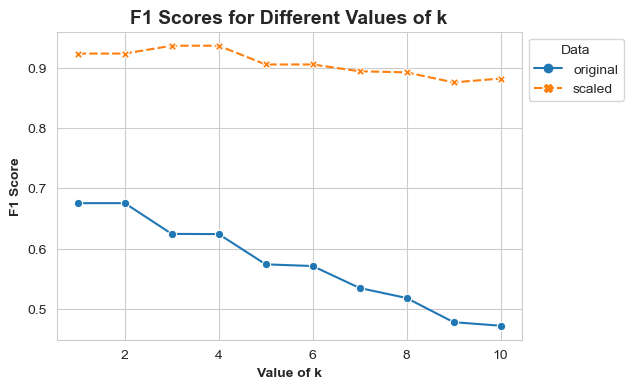

In [33]:
# Create a dataframe to store the result
f1_result = pd.DataFrame({
    'data': ['original' for x in range(10)] + ['scaled' for x in range(10)],
    'k': [x for x in range(1, 11)] + [x for x in range(1, 11)],
    'f1': original_result + scaled_result
})

# Plot the result for scaled and not scaled data
sns.set_style('whitegrid')
plt.figure(figsize=(6,4))

sns.lineplot(data=f1_result, x='k', y='f1', hue='data',
             style='data', markers=True)

plt.title('F1 Scores for Different Values of k', fontsize=14, fontweight='bold')
plt.xlabel('Value of k', fontweight='bold')
plt.ylabel('F1 Score', fontweight='bold')
plt.legend(title='Data', loc='upper left', bbox_to_anchor=(1,1))

plt.show()

**Conclusion**

The KNN algorithm is able to predict if a new customer will received a insureance benefit. With feature scaling, KNN classifier produces more consistent and meaningful result.

[Back to Contents](#back)

### 4.3 Regression (with Linear Regression) <a id='regression'></a>

In this section, a linear regression model will be used to predict the number of insurance benefits received by a new customer. The model will be evaluated with the RMSE and r squared metrics for both the original data and the scaled data. Before developing the model, let's take a look on how the linear algebra works behind the linear regression algorithm.

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities (for bias)
- $y$ — target (a vector)
- $\hat{y}$ — estimated target (a vector)
- $w$ — weight vector
- $\epsilon$ — residual vector
- $n$ — number of cases

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

In real world application, there are factors influencing $y$ which are not captured by the features $X$, these factors are represented by the error term $\epsilon$ (residual). Thus, $y$ is represented as

$$\begin{align*}
y &= Xw + \epsilon \\
\epsilon &= y - Xw
\end{align*}$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

where

$$\begin{align*}
\text{MSE}(Xw, y) &= \frac{1}{n} \sum_{i=1}^{n} (X^{(i)} w - y^{(i)})^2 \\
&= \frac{1}{n} (Xw - y)^T (Xw - y)
\end{align*}$$

Take the partial derivative of MSE with respect to $w$ to find the gradient

$$
\nabla \text{MSE}(Xw, y) = \frac{2}{n} X^T (Xw - y)
$$

To minimise the MSE, let the gradient equal to 0

$$\begin{align*}
\nabla \text{MSE}(Xw, y) &= 0 \\
\frac{2}{n} X^T (Xw - y) &= 0 \\
X^T Xw - X^Ty &= 0 \\
X^T Xw &= X^Ty \\
(X^T X)^{-1} (X^T X)w &= (X^T X)^{-1} X^Ty  \\
Iw &= (X^T X)^{-1} X^Ty 
\end{align*}$$

Therefore, the analytical solution for $w$ which minimise the MSE is

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

**Original Data**

We have seen that the results of KNN algorithm are different for the original data and scaled data. Let's have an investigate if this is an issue for the linear regression algorithm.

First, we will look at the original data.

In [34]:
# Train and evaluate the linear regression model
lr_1 = MyLinearRegression()
lr_1.fit(X_train, y_train)
lr_1_pred = lr_1.predict(X_test)
eval_regressor(y_test, lr_1_pred)

RMSE: 0.24
R2: 0.44


The model has a fairly good RMSE score of 0.24

**Scaled Data**

Now, let's see if the RMSE and r2 scores for the scaled data are different from those of the original data.

In [35]:
# Scaled the data
mas = MaxAbsScaler()
X_train_scaled = mas.fit_transform(X_train)
X_test_scaled = mas.transform(X_test)

In [36]:
# Train and evaluate the linear regression model
lr_2 = MyLinearRegression()
lr_2.fit(X_train_scaled, y_train)
lr_2_pred = lr_2.predict(X_test_scaled)
eval_regressor(y_test, lr_2_pred)

RMSE: 0.24
R2: 0.44


For the sacled data, the RMSE and r squared scores are same as those of the original data. 

This result shows that feature scaling has not effect on the result of a linear regression model. In this instance, the original features $X$ is scaled by dividing the maximum values of features, the linear regression algorithm will compensate this by multiplying the original weights $w$ with the maximum values of features. Let's have a check on this reasoning.

In [37]:
# Print the weights of features for original data
print('The maximum values of the original features')
print(X_train.max().values, '\n')

print('Weights from the original data')
print(lr_1.weights[1:5], '\n')

print('Original weights multiplied by the maximum values of the original features')
print((lr_1.weights[1:5] * X_train.max()).values, '\n')

print('Weights from the scaled data')
print(lr_2.weights[1:5])

The maximum values of the original features
[1.00e+00 6.50e+01 7.48e+04 6.00e+00] 

Weights from the original data
[ 4.40575926e-03  2.49959715e-02  4.78518715e-07 -8.71639714e-03] 

Original weights multiplied by the maximum values of the original features
[ 0.00440576  1.62473815  0.0357932  -0.05229838] 

Weights from the scaled data
[ 0.00440576  1.62473815  0.0357932  -0.05229838]


In [38]:
# Check if the two arrays are element-wise equal within a tolerance.
np.allclose((lr_1.weights[1:5] * X_train.max()).values, lr_2.weights[1:5])

True

Here shows the reason why the linear regression model is not affected by feature scaling.

**Conclusion**

The number of insurance benefits received by a customer can be predicted with a linear regression model. Unlike KNN model, linear regression model does not required feature scaling for the model to work correctly.

[Back to Contents](#back)

### 4.4 Obfuscating Data <a id='data_obfuscation'></a>

To protect the customer privacy, the numerical features in the data can be obfuscated by multiplying by an invertible matrix $P$.

$$
X_{p} = XP
$$

where

$$
X_{p}: \text{Obfuscated Features}
$$

In [39]:
# Create a dataframe to store the customers perfonal information
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
data_pn = data[personal_info_column_list]

In [40]:
# Create the matrix of personal information
X = data_pn.values

# Generating a random matrix P
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

# Have a look at P
P

array([[0.77395605, 0.43887844, 0.85859792, 0.69736803],
       [0.09417735, 0.97562235, 0.7611397 , 0.78606431],
       [0.12811363, 0.45038594, 0.37079802, 0.92676499],
       [0.64386512, 0.82276161, 0.4434142 , 0.22723872]])

In [41]:
# Check if P is invertible
np.linalg.inv(P)

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

In [42]:
# Encrypt the original data by multipling P and store in data_pn
X_obfuscated = X @ P
data_obfuscated = pd.DataFrame(X_obfuscated, columns=personal_info_column_list)

# Have a look at the enrypted data
data_obfuscated.head()

,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631
3,5345.603937,18803.227203,15479.148373,38663.061863
4,3347.176735,11782.829283,9699.998942,24211.273378


After obfuscating the data, it is impossible to know the original values and thus the personal information of customers is secured. In the event of a data breach, sensitive data will be useless without having the decryption key. Here, the decryption key is $P^{-1}$, the inverse matrix of $P$.

$$\begin{align*}
X_{p} &= XP \\
X_{p} P^{-1} &= XPP^{-1} \\
X_{p} P^{-1} &= XI \\
\therefore X &= X_{p} P^{-1}
\end{align*}$$

Therefore, it is important that the matrix $P$ is invertible so that we can decrypt the obfuscated data with $P^{-1}$. Now, let's try to recover the data.

In [43]:
# Recover the data with the decryption key, P inverse
X_decrypted = X_obfuscated @ np.linalg.inv(P)
data_decrypted = pd.DataFrame(X_decrypted, columns=personal_info_column_list)

# Have a look at data_decrypted
data_decrypted[:5]

,gender,age,income,family_members
0,1.000000e+00,41.0,49600.0,1.000000e+00
1,-3.637979e-12,46.0,38000.0,1.000000e+00
2,1.818989e-12,29.0,21000.0,0.000000e+00
3,0.000000e+00,21.0,41700.0,2.000000e+00
4,1.000000e+00,28.0,26100.0,3.637979e-12


It seems like the data is recovered with a small margin of rounding error. This error is likely due to the finite precision of floting-point numbers. This error may occur when the calculation involves small numbers close to zero especally in a matrix inversion. Let's check if this error is tolerable.

In [44]:
# Check if the two datasets are element-wise equal within a tolerance.
np.allclose(X, X_decrypted)

True

In [45]:
# Round the decrypted data and update the data_pn
data_decrypted.update(
    pd.DataFrame(abs(X_decrypted.round()), columns=personal_info_column_list)
)

In [46]:
# Show the important results in the data encryption and decryption process
print('\033[1m', 'Original Data')
display(data_pn.head(3))
print('*' * 50)

print('\033[1m', 'Obfuscating data with P')
display(data_obfuscated.head(3))
print('*' * 50)

print('\033[1m', 'Decrypting Data with P inverse')
display(data_decrypted.head(3))

 Original Data


,gender,age,income,family_members
0,1,41,49600.0,1
1,0,46,38000.0,1
2,0,29,21000.0,0


**************************************************
 Obfuscating data with P


,gender,age,income,family_members
0,6359.715273,22380.404676,18424.090742,46000.696690
1,4873.294065,17160.367030,14125.780761,35253.455773
2,2693.117429,9486.397744,7808.831560,19484.860631


**************************************************
 Decrypting Data with P inverse


,gender,age,income,family_members
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0


Nice, we have successfully obfuscated and decrypted the data. 

**Conculsion**

The customer private information can be obfuscated by multiplying a square matrix $P$. However, we have to make sure $P$ is invertible so that the data can be recovered if needed.

[Back to Contents](#back)

## 5. Proving That Data Obfuscation Can Work with Linear Regression <a id='data_obfuscation_lr'></a>

A mathematical proof will be provided here to show that a linear regression model can work with the obsfuscated data. 

$$\begin{align*}
y &= Xw \tag{1} \\
y_{p} &= X_{p}w_{p} \tag{2} \\
\end{align*}$$

where

$$\begin{align*}
X_{p} &= XP \tag{3} \\
w &= (X^T X)^{-1} X^T y \tag{4} \\
w_{p} &= [(XP)^T XP]^{-1} (XP)^T y \tag{5}
\end{align*}$$

To prove that the linear regression work correctly with the obfuscated data, it is equivalent to prove that

$$
y_{p} = y
$$

Proof:

From (5)
$$\begin{align*}
w_{p} &= [(XP)^T XP]^{-1} (XP)^T y \\
&= (P^T X^T XP)^{-1} (XP)^T y \\
&= [(P^T X^T X) P]^{-1} (XP)^T y \\
&= P^{-1} (P^T X^T X)^{-1} (XP)^T y \\
&= P^{-1} [P^T (X^T X)]^{-1} (XP)^T y \\
&= P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y \\
&= P^{-1} (X^T X)^{-1} [(P^T)^{-1} P^T] X^T y \\
&= P^{-1} (X^T X)^{-1} I X^T y \\
&= P^{-1} (X^T X)^{-1} (I X^T) y \\
\therefore w_{p} &= P^{-1} [(X^T X)]^{-1} X^T y \tag{6} \\
\end{align*}$$

Substitute (4) into (6)

$$\begin{align*}
w_{p} &= P^{-1} w \tag{7} \\
\end{align*}$$

Substitute (3) and (7) into (2)
$$\begin{align*}
y_{p} &= XP P^{-1}w \tag{2} \\
&= X(P P^{-1}) w \\
&= XIw \\
&= Xw \\
\therefore y_{p} &= y
\end{align*}$$

The above proof provides the evidence that the values of $y_{p}$ from the obfuscated data are equal to the values of $y$ from the original data.

[Back to Contents](#back)

### 6.  Test Linear Regression With Data Obfuscation <a id='data_obfuscation_test'></a>

We have prove that the linear regression model can work with the obfuscated data to give the same prediction as the original data. Now, we will verify this by running the linear regression model for both the original data and the obfuscated data. The results will be compared by using the RMSE and r squared metrics.

In [47]:
class MyLinearRegression:
    def __init__(self):
        self.weights = None
        
    def fit(self, X_train, y_train):
        # Adding the unities for bias
        X2 = np.append(np.ones([len(X_train), 1]), X_train, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y_train
    
    def predict(self, X_test):
        # Adding the unities for bias
        X3 = np.append(np.ones([len(X_test), 1]), X_test, axis=1)
        y_pred = X3 @ self.weights
        
        return y_pred

**Original Data**

In [48]:
# Train and evaluate the linear regression model
lr_3 = MyLinearRegression()
lr_3.fit(X_train, y_train)
lr_3_pred = lr_3.predict(X_test)
eval_regressor(y_test, lr_3_pred)

RMSE: 0.24
R2: 0.44


**Obfuscated Data**

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check if $P$ is invertible. If not, repeat the first point until we get an invertible matrix.
- Multiply the training feature matrix $X_{train}$ and the test feature matrix $X_{test}$ by $P$.
- Use $X_{train}P$ to train and $X_{test}P$ to evaluate the model.

In [49]:
# Create a random nxn square matrix P
# n is the number of features
n = X_train.shape[1]
rng = np.random.default_rng(seed=12345)
P = rng.random(size=(n, n))

In [50]:
# Check if P is invertible
np.linalg.inv(P)

array([[-1.97240014,  1.76004024, -0.08309671,  1.22285233],
       [ 0.14111106,  0.32873452,  1.02824721, -1.27752175],
       [ 0.8908452 ,  0.90302415, -0.59501472, -0.23290483],
       [ 1.02530945, -1.81039816,  0.24787878,  0.46192295]])

With an invertible P, the linear regression algorithm can work correctly with the obfuscated data

In [51]:
# Create the obfuscated data
X_train_P = pd.DataFrame(X_train.values @ P, columns=X_train.columns)
X_test_P = pd.DataFrame(X_test.values @ P, columns=X_train.columns)

# Take a look at the obfuscated data
print('\033[1m', 'Obfuscated training set')
display(X_train_P.head())
print('*' * 60)

print('\033[1m', 'Obfuscated test set')
display(X_test_P.head())

 Obfuscated training set


,gender,age,income,family_members
0,24968.748217,34948.620864,9224.318010,35209.161620
1,28342.354967,39665.401864,10479.550468,39958.259225
2,27995.646951,39186.653916,10340.782830,39477.750803
3,31497.107256,44086.691326,11636.447016,44413.426666
4,22074.332789,30897.537288,8154.468203,31128.225730


************************************************************
 Obfuscated test set


,gender,age,income,family_members
0,31763.308133,44461.066719,11731.756197,44792.161507
1,44347.366142,62075.775625,16379.335840,62537.919654
2,22820.898318,31938.608546,8436.954960,32175.682490
3,13000.779397,18189.966839,4815.360013,18322.461823
4,18520.116725,25915.080031,6855.163034,26104.594408


In [52]:
# Train and evaluate the linear regression model
lr_4 = MyLinearRegression()
lr_4.fit(X_train_P, y_train)
lr_4_pred = lr_4.predict(X_test_P)
eval_regressor(y_test, lr_4_pred)

RMSE: 0.24
R2: 0.44


The two models give the identical RMSE and r squared scores regardless the data is obfuscated or not. The linear regression model will adjust weights for different datasets and give the same prediction. Let's verify this.

In [53]:
# Print the weights from the both models
print('Weights from the original data')
print(lr_3.weights, '\n')

print('Weights from the obfuscated data')
print(lr_4.weights, '\n')

print('Prediction from the original data')
print(lr_3_pred, '\n')

print('Prediction from the obfuscated data')
print(lr_4_pred)

Weights from the original data
[-6.69815605e-01  4.40575926e-03  2.49959715e-02  4.78518715e-07
 -8.71639714e-03] 

Weights from the obfuscated data
[-0.66981566  0.02464497  0.01997461  0.02852668 -0.0447615 ] 

Prediction from the original data
[-0.06791642  0.16599563  0.15824621 ...  0.23892114  0.10524356
  0.22015585] 

Prediction from the obfuscated data
[-0.06791631  0.16599576  0.15824631 ...  0.23892132  0.10524355
  0.220156  ]


In [54]:
# Check if the two predictions are element-wise equal within a tolerance.
# The original parameter atol=1e-8 does not give a True answer
# np.allclose(lr_3_pred, lr_4_pred)
np.allclose(lr_3_pred, lr_4_pred, atol=1e-6)

True

The predictions from both the models are indeed the same but the error is slighly higher than the expectation and this might due to our simplified linear regression model. We can verify the result again by using the `LinearRegression` model from the sklearn library.

In [55]:
# Train and evaluate the sklearn linear regression model
# Use the obfuscated data
lr_5 = LinearRegression()
lr_5.fit(X_train_P, y_train)
lr_5_pred = lr_5.predict(X_test_P)
eval_regressor(y_test, lr_4_pred)

RMSE: 0.24
R2: 0.44


In [56]:
# Check if the two predictions from the original data and obfuscated data
# are element-wise equal within a tolerance.
np.allclose(lr_3_pred, lr_5_pred)

True

The two prediction results are verified to be the same in a higher precision.

**Conclusion**

From the implementation above, it has been proven that the obfuscated data can work with the linear regression model and produce the same result as the original data.

[Back to Contents](#back)

# 7. General Conclusion <a id='general_conclusion'></a>

**Data Exploration and Preprocessing**

The Sure Tomorrow company has provided us the dataset with 5000 customers data which include the `gender`, `age`, `income`, `family members` and `insurance benefits` information. The datasets have no missing values and outliers but there were 153 duplicated rows. These duplicated rows have been dropped.

**Exploratory Data Analysis**

The target `insurance benefits` is found to be imbalanced with 88.38% of customers never received any benefit before. This might pose a problem for a classification model. 

**Solving the Tasks Given by the Sure Tomorrow Company**

Task 1. Similar Customers
- The similar customers can be found by using the K-Nearest Neighbors (KNN) algorithm which calculates the 'distance' between the features. Since the calculation is distance-based, the data should be scaled accordingly so that the distance-based algorithm KNN takes these features in the same order of importance. 

Task 2. Is Customer Likely to Receive Insurance Benefit?
- By building a simplified KNN classifier, we can predict whether a new customer will receive insurance benefit. The KNN model perform poorly without scaling the features. With feature scaling, the KNN model has the highest f1-score of 94% for k=3 and k=4.

Task 3. Regression (with Linear Regression)
- By building a simplified linear regression model, the number of insurance benefits received by the customers can be predicted. The model gives a RMSE of 0.24 and r squared score of 44%, regardless the data is scaled or not scaled ( unlike the KNN model. Therefore, the linear regression is not affected by a scaled data and this has been proven mathematically.

Task 4 Obfuscating Data
- The customer personal data can be infuscated by multipling the original data by a random square matrix $P$. The original data is proven can be recovered by the obfuscated data by $P^{-1}$. Therefore, it is important to make sure $P$ is invertible so that we can recover the data if needed.

**Proving That Data Obfuscation Can Work with Linear Regression**
- A mathematical proof provides the evidence that the values of $y_{p}$ from the obfuscated data are equal to the values of $y$ from the original data. 
- This is further proved computationally by running the linear regression model for both the original data and the obfuscated data. The model has the same RMSE and r squared scores as above mentioned.

[Back to Contents](#back)